In [129]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
plt.style.use("dark_background")
import pickle
import lightgbm as lgb
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.classifier import StackingClassifier

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import precision_score, confusion_matrix, f1_score, accuracy_score, recall_score, classification_report, roc_auc_score
from sklearn.preprocessing import label_binarize, normalize

from utils import DataLoader, DataProcesser, label_plot, TimeKeeper

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
label_dic = {1: 'Still', 2: 'Walking', 3: 'Run', 4: 'Bike', 5: 'Car', 6: 'Bus', 7: 'Train', 8: 'Subway'}

In [117]:
cross_val_score(model_lr, X_train, y_train, scoring='accuracy', cv=5)

array([0.48921184, 0.48986512, 0.4850399 , 0.48667806, 0.49041967])

# Data

In [7]:
# train
data = DataLoader.SHLDataLoader('data/train/', ratio = None)
data.df = pd.read_csv('data/mid_res/20210525_data_df.csv')
dp = DataProcesser.DataProcesser(data)
dp.process_data_more()

Customized DataLoader Passed in.
------------------------ Windows Features Extracted ------------------------
New Feature Added: {'speed_wd_max_log', 'acc_wd_std_log'}


In [40]:
# validate
with open('data/mid_res/val_ft.pickle', 'rb') as file:
    val = pickle.load(file)
dp_val = DataProcesser.DataProcesser(val)
dp_val.process_data_more()

Customized DataLoader Passed in.
------------------------ Windows Features Extracted ------------------------
New Feature Added: {'speed_wd_std', 'speed_wd_max_log', 'acc_wd_std_log'}


In [42]:
data.df.to_csv('data/mid_res/20210526_data_df.csv', header = True, index = False)
# data.df = pd.read_csv('data/mid_res/20210526_data_df.csv')
val.df.to_csv('data/mid_res/20210526_val_df.csv', header = True, index = False)
# val.df = pd.read_csv('data/mid_res/20210526_val_df.csv')

In [43]:
# list(data.df)

In [55]:
def data_have_source(data):
    data.df['have_loc'] = data.df.apply(lambda x: 1 if x['accuracy'] > -1 else 0, axis = 1)
    data.df['have_gps'] = data.df.apply(lambda x: 1 if x['num_gps'] > 0 else 0, axis = 1)
    data.df['have_wifi'] = data.df.apply(lambda x: 1 if x['num_wifi'] > 0 else 0, axis = 1)
    data.df['have_cells'] = data.df.apply(lambda x: 1 if x['num_cells'] > 0 else 0, axis = 1)

# data_have_source(data)
# data_have_source(val)

In [74]:
# data.df = data.df.drop(['have_loc', 'have_gps', 'have_wifi', 'have_cells'], axis = 1)
# val.df = val.df.drop(['have_loc', 'have_gps', 'have_wifi', 'have_cells'], axis = 1)

In [70]:
col_drop_x = ['time', 'label']
col_drop = ['latitude',
 'longitude',
 'altitude',
 'time_dlt',
 'valid_dlt',
 'east',
 'north',
 'east_dlt',
 'north_dlt',
 'east_speed',
 'north_speed',
 'cells_ctype_mode',
 'speed_dif',
 'speed_dlt',
 'speed',

 'wifi_rssi_min',
 'wifi_rssi_std',
 'wifi_rssi_mode',

 'cells_asuLevel_min',
 'cells_dbm_min',
 'cells_level_min',
 'cells_asuLevel_max',
 'cells_dbm_max',
 'cells_level_max',
 'cells_asuLevel_std',
 'cells_dbm_std'
 ]

In [71]:
list(data.df.drop(col_drop, axis = 1))

['time',
 'label',
 'accuracy',
 'num_gps',
 'num_wifi',
 'num_cells',
 'acc',
 'wifi_rssi_mean',
 'wifi_rssi_max',
 'wifi_freq_5ratio',
 'cells_isRegistered_mean',
 'cells_asuLevel_mean',
 'cells_dbm_mean',
 'cells_level_mean',
 'gps_snr_mean',
 'gps_snr_min',
 'gps_snr_max',
 'gps_snr_std',
 'speed_log',
 'acc_wd_std',
 'speed_wd_std',
 'speed_wd_max_log',
 'acc_wd_std_log']

# Model

In [98]:
def evaluate(y_true, y_pred):
    conf = confusion_matrix(y_true , y_pred)
    print(conf)
    sns.heatmap(conf)
    print(classification_report(y_true, y_pred, target_names = list(label_dic.values())))

In [90]:
test_ratio = 0.2
X = data.df.drop(col_drop + col_drop_x, axis = 1).fillna(0)
X_train, X_test, y_train, y_test = train_test_split(X, data.df['label'], test_size = test_ratio)
X_val, y_val = val.df.drop(col_drop + col_drop_x, axis = 1).fillna(0), val.df['label']

## LightGBM

In [91]:
X.shape, X_val.shape

((980527, 21), (143958, 21))

In [92]:
train_data = lgb.Dataset(X_train, label = y_train - 1)
test_data = lgb.Dataset(X_test, label = y_test - 1)
params={
    'learning_rate':0.1,
    'lambda_l1':0.1,
    'lambda_l2':0.2,
    'max_depth':6,
    'objective':'multiclass',
    'num_class':8,  
}
model_lgb = lgb.train(params, train_data, valid_sets = [test_data])

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007276 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 784421, number of used features: 21
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score -2.082277
[LightGBM] [Info] Start training from score -2.078571
[LightGBM] [Info] Start training from score -3.145314
[LightGBM] [Info] Start training from score -2.122417
[LightGBM] [Info] Start training from

In [93]:
pred_prob_lgb = model_lgb.predict(X_val)
pred_lgb = pred_prob_lgb.argmax(axis = 1) + 1

array([[17118,  7068,    13,    99,    15,   903,    77,  4543],
       [ 3906, 17953,   252,   741,   463,  1214,   767,   853],
       [    2,   828,   288,  1391,   258,     2,     0,     5],
       [  277,   975,  1574,  7868,    12,     7,    14,  1304],
       [  345,   388,     0,  1185,  9690,  3665,  4637,   563],
       [  472,    56,     8,    36,   197,  5378,  1558,  1473],
       [ 4274,    51,     0,   119,  3303,  1031, 12425,   605],
       [ 1019,   392,     0,    13,  2066,   222,  2664, 15333]])

[[17118  7068    13    99    15   903    77  4543]
 [ 3906 17953   252   741   463  1214   767   853]
 [    2   828   288  1391   258     2     0     5]
 [  277   975  1574  7868    12     7    14  1304]
 [  345   388     0  1185  9690  3665  4637   563]
 [  472    56     8    36   197  5378  1558  1473]
 [ 4274    51     0   119  3303  1031 12425   605]
 [ 1019   392     0    13  2066   222  2664 15333]]
              precision    recall  f1-score   support

       Still       0.62      0.57      0.60     29836
     Walking       0.65      0.69      0.67     26149
         Run       0.13      0.10      0.12      2774
        Bike       0.69      0.65      0.67     12031
         Car       0.61      0.47      0.53     20473
         Bus       0.43      0.59      0.50      9178
       Train       0.56      0.57      0.57     21808
      Subway       0.62      0.71      0.66     21709

    accuracy                           0.60    143958
   macro avg       0.54      0.54      0.54    14

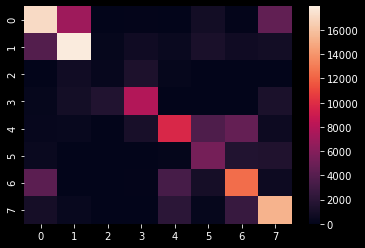

In [99]:
evaluate(y_val, pred_lgb)

## NB

In [96]:
model_nb = GaussianNB().fit(X_train, y_train)
pred_nb = model_nb.predict(X_val)

[[23467  2533    17    36    16   319   194  3254]
 [ 4404 11589  5969   196    43  3054   172   722]
 [   26   657  1876    88     1   120     1     5]
 [  461  1498  5350  2873     0    10    79  1760]
 [ 1432   285   191  5083  5528  6145  1121   688]
 [ 3709   237    43   636   188  4047   117   201]
 [12932   211     0   606  2216  1374  3873   596]
 [11508    62     0   128   247  1650    17  8097]]
              precision    recall  f1-score   support

       Still       0.41      0.79      0.53     29836
     Walking       0.68      0.44      0.54     26149
         Run       0.14      0.68      0.23      2774
        Bike       0.30      0.24      0.27     12031
         Car       0.67      0.27      0.39     20473
         Bus       0.24      0.44      0.31      9178
       Train       0.69      0.18      0.28     21808
      Subway       0.53      0.37      0.44     21709

    accuracy                           0.43    143958
   macro avg       0.46      0.43      0.37    14

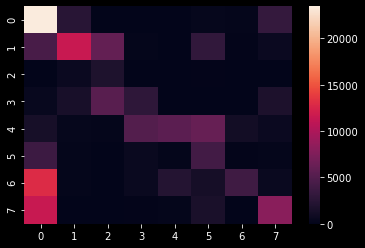

In [107]:
evaluate(y_val, pred_nb)

## LR

In [111]:
model_lr = LogisticRegression(random_state = 99).fit(X_train, y_train)
pred_lr = model_lr.predict(X_val)

[[14999  5518    24   869   387  3871  3168  1000]
 [ 3559  9374   122  2109   421  8707   991   866]
 [   54   475     2   706   288   961    28   260]
 [  407  2785   962  4880     0    14  1584  1399]
 [  767   614    25  2438  9331  2011  4195  1092]
 [ 2271   520    43   498   140  4272  1036   398]
 [ 6784  1108   410   557  5006   663  6344   936]
 [ 1446   435    12   383  1525   586  8969  8353]]
              precision    recall  f1-score   support

       Still       0.50      0.50      0.50     29836
     Walking       0.45      0.36      0.40     26149
         Run       0.00      0.00      0.00      2774
        Bike       0.39      0.41      0.40     12031
         Car       0.55      0.46      0.50     20473
         Bus       0.20      0.47      0.28      9178
       Train       0.24      0.29      0.26     21808
      Subway       0.58      0.38      0.46     21709

    accuracy                           0.40    143958
   macro avg       0.36      0.36      0.35    14

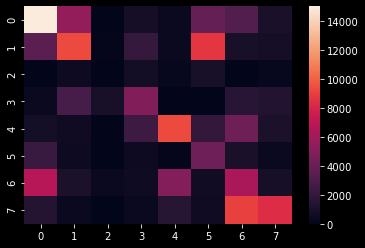

In [112]:
evaluate(y_val, pred_lr)

## Stacking

In [143]:
X_train2 = X_train.copy()
X_train2['prepred'] = model_lgb.predict(X_train).argmax(axis = 1) + 1

X_val2 = X_val.copy()
X_val2['prepred'] = model_lgb.predict(X_val).argmax(axis = 1) + 1

In [144]:
sclf = StackingClassifier(classifiers=[model_nb, model_lr], 
                          meta_classifier = LogisticRegression())

In [146]:
sclf.fit(X_train2, y_train)

StackingClassifier(classifiers=[GaussianNB(),
                                LogisticRegression(random_state=99)],
                   meta_classifier=LogisticRegression())

In [148]:
pred_sclf = sclf.predict(X_val2)

[[21952  2255     0    78    21   570   687  4273]
 [ 2933 18468     0  1389   313  1479  1021   546]
 [    7  1079     0  1388   188   105     1     6]
 [  378  3545     0  6701    75     2    16  1314]
 [  430   590     0  1500  8953  5210  2358  1432]
 [  450    79     0    41   121  5363  1995  1129]
 [ 4028   210     0   198  3227   534 11970  1641]
 [ 1245     5     0   186   273   515  4406 15079]]
              precision    recall  f1-score   support

       Still       0.70      0.74      0.72     29836
     Walking       0.70      0.71      0.71     26149
         Run       0.00      0.00      0.00      2774
        Bike       0.58      0.56      0.57     12031
         Car       0.68      0.44      0.53     20473
         Bus       0.39      0.58      0.47      9178
       Train       0.53      0.55      0.54     21808
      Subway       0.59      0.69      0.64     21709

    accuracy                           0.61    143958
   macro avg       0.52      0.53      0.52    14

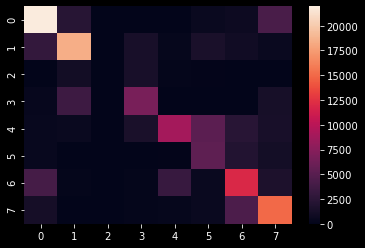

In [149]:
evaluate(y_val, pred_sclf)

## Voting

In [165]:
vclf = VotingClassifier(estimators=[model_nb, model_lr], voting='soft')

In [167]:
vclf.fit(X_train, y_train)

TypeError: 'GaussianNB' object is not iterable

In [163]:
cross_val_score(vclf, X_train, y_train, cv=5, scoring='accuracy')

array([nan, nan, nan, nan, nan])

In [164]:
cross_val_score(model_nb, X_train, y_train, cv=5, scoring='accuracy')

array([0.43567581, 0.43302695, 0.43419979, 0.4330142 , 0.43335203])